In [1]:
!pip install torchinfo

In [2]:
import torch, time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torchinfo import summary

In [3]:
if torch.cuda.is_available():
  print("Device:", torch.cuda.current_device())
  print("Name:", torch.cuda.get_device_name(torch.cuda.current_device()))

Device: 0
Name: Tesla T4


In [4]:
data = load_wine()
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names'])

In [5]:
print(data['DESCR'])

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

:Number of Instances: 178
:Number of Attributes: 13 numeric, predictive attributes and the class
:Attribute Information:
    - Alcohol
    - Malic acid
    - Ash
    - Alcalinity of ash
    - Magnesium
    - Total phenols
    - Flavanoids
    - Nonflavanoid phenols
    - Proanthocyanins
    - Color intensity
    - Hue
    - OD280/OD315 of diluted wines
    - Proline
    - class:
        - class_0
        - class_1
        - class_2

:Summary Statistics:

============================= ==== ===== ======= =====
                                Min   Max   Mean     SD
============================= ==== ===== ======= =====
Alcohol:                      11.0  14.8    13.0   0.8
Malic Acid:                   0.74  5.80    2.34  1.12
Ash:                          1.36  3.23    2.36  0.27
Alcalinity of Ash:            10.6  30.0    19.5   3.3
Magnesium:                    70.0 162.0    99.7  14.3

In [6]:
features = data['feature_names']
features

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

In [7]:
X, y = load_wine(return_X_y=True)

In [8]:
X = pd.DataFrame(X,columns=features)
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [9]:
X.shape

(178, 13)

In [10]:
y.shape

(178,)

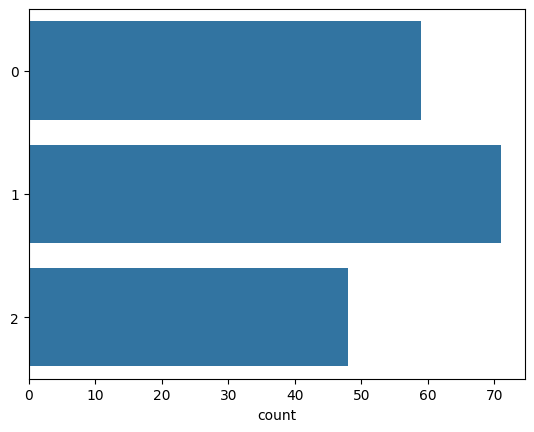

In [11]:
sns.countplot(y=y,orient="h");

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
X_train = torch.FloatTensor(X_train).cuda()
X_test = torch.FloatTensor(X_test).cuda()
y_train = torch.LongTensor(y_train).cuda()
y_test = torch.LongTensor(y_test).cuda()

In [15]:
class ANN(nn.Module):
  def __init__(self,num_features):
    super(ANN,self).__init__()
    self.network = nn.Sequential(
        nn.Linear(num_features,64),
        nn.ReLU(),
        nn.Linear(64,32),
        nn.ReLU(),
        nn.Linear(32,3),
        nn.LogSoftmax(dim=1)
    )

  def forward(self,X):
    return self.network(X)

In [16]:
torch.manual_seed(42)
model = ANN(num_features=X_train.shape[1]).cuda()
model

ANN(
  (network): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=3, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

In [17]:
summary(model,input_size=(1,X_train.shape[1]))

Layer (type:depth-idx)                   Output Shape              Param #
ANN                                      [1, 3]                    --
├─Sequential: 1-1                        [1, 3]                    --
│    └─Linear: 2-1                       [1, 64]                   896
│    └─ReLU: 2-2                         [1, 64]                   --
│    └─Linear: 2-3                       [1, 32]                   2,080
│    └─ReLU: 2-4                         [1, 32]                   --
│    └─Linear: 2-5                       [1, 3]                    99
│    └─LogSoftmax: 2-6                   [1, 3]                    --
Total params: 3,075
Trainable params: 3,075
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01

In [18]:
total_params = 0

for param in model.parameters():
  print(param.numel())
  total_params += param.numel()

print("Total parameters:",total_params)

832
64
2048
32
96
3
Total parameters: 3075


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(),lr=0.001)

In [20]:
epochs = 100

train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

start_time = time.time()

for epoch in range(1,epochs+1):

  y_pred = model(X_train)
  loss = criterion(y_pred,y_train)
  train_losses.append(loss.item())

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  predicted = torch.max(y_pred,1)[1]
  train_correct_predictions.append((predicted==y_train).sum().item())

  model.eval() # Set model to evaluation mode

  with torch.no_grad():
    y_pred = model(X_test)
    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())

    predicted = torch.max(y_pred,1)[1]
    test_correct_predictions.append((predicted==y_test).sum().item())

  model.train() # Set model back to training mode

  if epoch % 10 == 0:
    print("Epoch:",epoch,"Train Loss:",train_losses[-1],"Test Loss:",test_losses[-1])
    print("Epoch:",epoch,"Train Accuracy:",train_correct_predictions[-1]/len(y_train),"Test Accuracy:",test_correct_predictions[-1]/len(y_test))

Epoch: 10 Train Loss: 0.9555416703224182 Test Loss: 0.9324378967285156
Epoch: 10 Train Accuracy: 0.8802816901408451 Test Accuracy: 0.8888888888888888
Epoch: 20 Train Loss: 0.7821936011314392 Test Loss: 0.7542767524719238
Epoch: 20 Train Accuracy: 0.9366197183098591 Test Accuracy: 0.9722222222222222
Epoch: 30 Train Loss: 0.5813440084457397 Test Loss: 0.549695611000061
Epoch: 30 Train Accuracy: 0.9647887323943662 Test Accuracy: 0.9722222222222222
Epoch: 40 Train Loss: 0.3889113664627075 Test Loss: 0.35757535696029663
Epoch: 40 Train Accuracy: 0.971830985915493 Test Accuracy: 0.9722222222222222
Epoch: 50 Train Loss: 0.24502423405647278 Test Loss: 0.21566884219646454
Epoch: 50 Train Accuracy: 0.9788732394366197 Test Accuracy: 1.0
Epoch: 60 Train Loss: 0.15413613617420197 Test Loss: 0.12928542494773865
Epoch: 60 Train Accuracy: 0.9859154929577465 Test Accuracy: 1.0
Epoch: 70 Train Loss: 0.10089237242937088 Test Loss: 0.08109288662672043
Epoch: 70 Train Accuracy: 0.9929577464788732 Test Accu

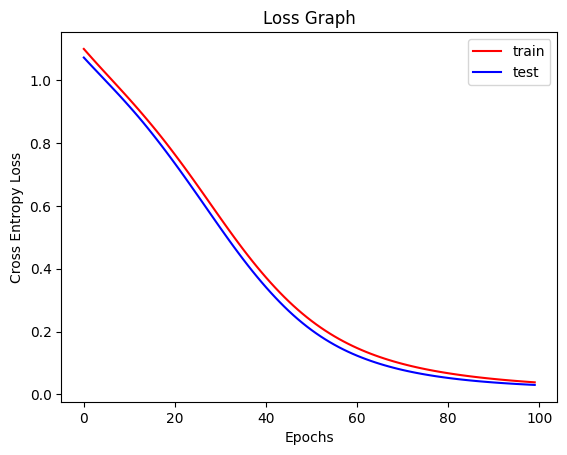

In [21]:
plt.plot(train_losses,'r',label='train')
plt.plot(test_losses,'b',label='test')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

In [22]:
train_accuracies = [x/len(y_train) for x in train_correct_predictions]
test_accuracies = [x/len(y_test) for x in test_correct_predictions]

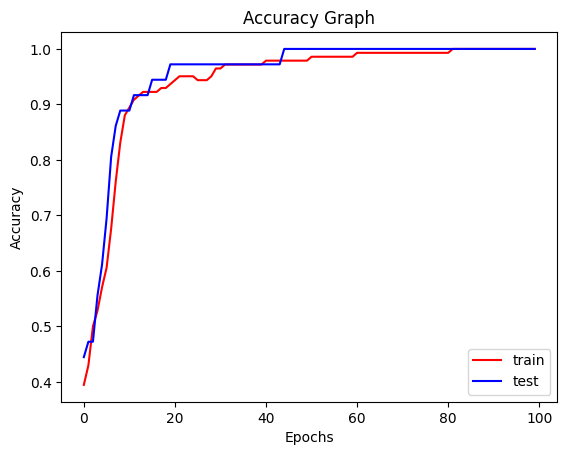

In [23]:
plt.plot(train_accuracies,'r',label='train')
plt.plot(test_accuracies,'b',label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

In [24]:
torch.save(model,'wine_classifier.pt')

In [25]:
loaded_model = torch.load('wine_classifier.pt')
loaded_model

<ipython-input-25-beb463420649>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load('wine_classifier.pt')


ANN(
  (network): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=3, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

In [28]:
loaded_model.eval()

while True:
  alcohol = float(input("Alcohol:"))
  malic_acid = float(input("Malic Acid:"))
  ash = float(input("Ash:"))
  ash_alkalinity = float(input("Ash Alcalinity:"))
  magnesium = float(input("Magnesium:"))
  total_phenols = float(input("Total Phenols:"))
  flavanoids = float(input("Flavanoids:"))
  nonflavanoid_phenols = float(input("Nonflavanoid Phenols:"))
  proanthocyanins = float(input("Proanthocyanins:"))
  color_intensity = float(input("Color Intensity:"))
  hue = float(input("Hue:"))
  diluted_wines = float(input("Diluted Wines:"))
  proline = float(input("Proline:"))

  test_data = pd.DataFrame([[alcohol,malic_acid,ash,ash_alkalinity,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,diluted_wines,proline]],columns=features)
  wine = torch.FloatTensor(scaler.transform(test_data)).cuda()

  loaded_model.eval()

  with torch.no_grad():
    output = loaded_model(wine)
    _, predicted = torch.max(output,1)
    print("Predicted Class:",predicted.item())

  if predicted.item() == 0:
    print("Class 0")
  elif predicted.item() == 1:
    print("Class 1")
  else:
    print("Class 2")

  choice = input("\n Do you want to continue? (y/n)")
  if choice.lower() != 'y':
    break

Alcohol:12.03
Malic Acid:3.6
Ash:2.24
Ash Alcalinity:14.93
Magnesium:136.71
Total Phenols:1.97
Flavanoids:4.82
Nonflavanoid Phenols:2.31
Proanthocyanins:3.08
Color Intensity:9.4
Hue:0.56
Diluted Wines:3.2
Proline:1264.3
Predicted Class: 1
Class 1

 Do you want to continue? (y/n)y
Alcohol:13.45
Malic Acid:3.42
Ash:1.09
Ash Alcalinity:20.9
Magnesium:81.0
Total Phenols:1.64
Flavanoids:2.57
Nonflavanoid Phenols:0.52
Proanthocyanins:2.91
Color Intensity:1.96
Hue:1.17
Diluted Wines:3.37
Proline:473.2
Predicted Class: 1
Class 1

 Do you want to continue? (y/n)n


In [27]:
for col in X.columns:
  print(col,X[col].min(),X[col].max())

alcohol 11.03 14.83
malic_acid 0.74 5.8
ash 1.36 3.23
alcalinity_of_ash 10.6 30.0
magnesium 70.0 162.0
total_phenols 0.98 3.88
flavanoids 0.34 5.08
nonflavanoid_phenols 0.13 0.66
proanthocyanins 0.41 3.58
color_intensity 1.28 13.0
hue 0.48 1.71
od280/od315_of_diluted_wines 1.27 4.0
proline 278.0 1680.0
